In [1]:
import csv, glob, os, sys, numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
import timeit, math, inspect
from scipy.optimize import curve_fit
from scipy import optimize
from scipy.interpolate import griddata
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from scipy import signal
from numpy import NaN, Inf, arange, isscalar, asarray, array
import numpy.polynomial.polynomial as poly

plt.rcParams['xtick.labelsize'] = 15; plt.rcParams['ytick.labelsize'] = 15 #make size of axis tick labels larger

# DEFINE FITTING FUNCTIONS
def rsquared(y, fit): #r^2 value for quantification of fitting errors
    residuals = y - fit #find residuals 
    r_square_value = 1 - (np.sum(residuals**2) / np.sum((y-np.mean(y))**2)) #r^2 value
    return r_square_value

filename='allQCMtaus.csv' #frequency filename
rawdata = pd.read_csv(filename)#, skiprows=698, header=0, error_bad_lines=False, sep='\s+') #read in file
print(rawdata)

   RH  Pressure   d16h2o    d8h20   d4h2o    d0h2o  uv16h2o   uv8h20   uv4h2o  \
0   1     0.242  22.9800  44.7828  16.600  15.6000  23.7800  64.5564  40.7000   
1  10     2.380  24.9900  31.2200  18.840  22.8000  32.9000  46.3700  57.0000   
2  30     7.126  29.5500  28.8900  21.600  17.1000  40.0000  48.3900  52.6800   
3  60    14.147  27.0000  25.4000  25.100  17.2800  36.8400  43.3400  49.9000   
4  95    22.600  20.7726  21.8832  25.404  15.9594  28.3296  34.5678  34.5936   

    uv0h2o  d16o2  d8o2  d4o2   d0o2  uv16o2     uv8o2  uv4o2     uv0o2  
0  84.6000   5.40   4.8  10.0  2.400   24.66   80.4000  102.0  140.0000  
1  65.8000   2.40   3.6  15.0  3.000   84.00  102.0000   84.0  130.0000  
2  54.6000   5.00   4.8  25.8  1.200   58.34   73.2000   67.8  107.0000  
3  46.3800   8.00  13.8  15.6  1.800   52.00   57.8400   60.0   65.4000  
4  32.7228   7.38  15.0   5.7  2.418   40.62   65.3604   79.2   56.3226  


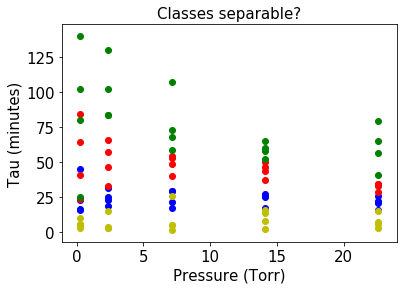

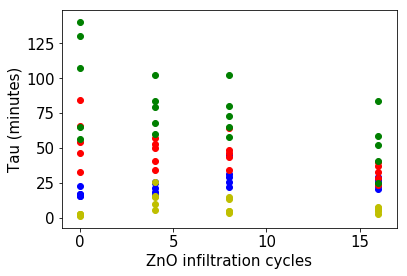

In [2]:
p = np.array(rawdata['Pressure']) #make array of pressures
rh = np.array(rawdata['RH'])
data = rawdata.drop('RH', 1).drop('Pressure', 1) #drop RH and pressure values from dataframe
names = list(data) #list of sample names

siglist = np.array([]) #make list of signal values
for column in data:
    siglist = np.hstack((siglist, data[column]))
sig = np.reshape(siglist,(len(list(data)),-1)) #reshape into signal matrix

# plot classes as tau vs. pressure
colors = ['b', 'r', 'y', 'g']
labels = ['dark H2O', 'UV H2O', 'dark O2', 'UV O2']
for i in range(0,len(sig),4):
    for j in range(4):
        plt.scatter(p, sig[i+j], c=colors[int(i/4)], label = labels[int(i/4)])
plt.title('Classes separable?', fontsize=15)
plt.xlabel('Pressure (Torr)', fontsize=15); plt.ylabel('Tau (minutes)', fontsize=15)
#plt.legend(); 
plt.show()

# plot classes as tau vs. # of ZnO infiltration cycles
cyclenumber = np.array([[16,16,16,16,16],[8,8,8,8,8],[4,4,4,4,4],[0,0,0,0,0],
                       [16,16,16,16,16],[8,8,8,8,8],[4,4,4,4,4],[0,0,0,0,0],
                       [16,16,16,16,16],[8,8,8,8,8],[4,4,4,4,4],[0,0,0,0,0],
                        [16,16,16,16,16],[8,8,8,8,8],[4,4,4,4,4],[0,0,0,0,0]])

for i in range(0,len(sig),4):
    for j in range(4):
        plt.scatter(cyclenumber[i+j], sig[i+j], c=colors[int(i/4)])
plt.xlabel('ZnO infiltration cycles', fontsize=15); plt.ylabel('Tau (minutes)', fontsize=15)
plt.show()

In [24]:
#######################################################################
# MULTI-CLASS SVM USING SKLEARN
from sklearn import svm, datasets
from sklearn.preprocessing import Normalizer

### Import data from CSV file
classdata = pd.read_csv('allPressureQCMtaus.csv')
list(classdata.columns.values) #to display all headers

pressures = np.array(classdata['pressure'])
cycles = np.array(classdata['cycles'])
taus = np.array(classdata['tau'])
classes = np.array(classdata['class']) #classes: 1 = h2o dark, 2 = h2o UV, 3 = o2 dark, 4 = o2 UV

#insert arrays to be used as columns for input matrix (e.g. x, y, z coords.)
inputlist = ([
    cycles,
    taus])
#insert array to be used as column for target matrix (class number)
targetlist = ([
    classes.astype(int)])
  #  presscol)
###################################################################################################
#see if input/target lists are multi-dimensional and convert to matrices
if len(np.shape(inputlist)) > 1:
    inputmatrix = np.array(zip(*inputlist)) #create input matrix
else:
    inputmatrix = inputlist.reshape(len(inputlist),1) #change to '),1)' if necessary
    
if len(np.shape(targetlist)) > 1:
    targetmatrix = np.array(zip(*targetlist)) #create target matrix
else:
    targetmatrix = targetlist.reshape(len(targetlist),1) #change to '),1)' if necessary
    
X = inputmatrix; y = targetmatrix #X = inputs/predictors, y = targets/classes

0
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) score = 0.8625


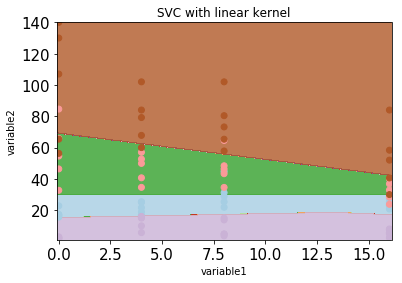

1
LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0) score = 0.4625


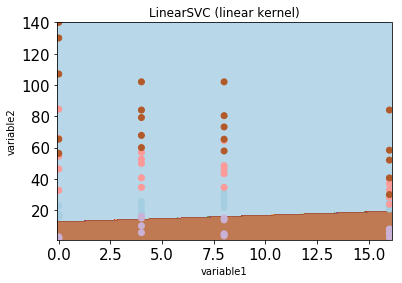

2
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=500, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) score = 1.0


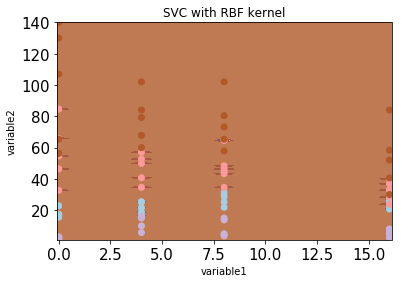

3
SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False) score = 0.8625


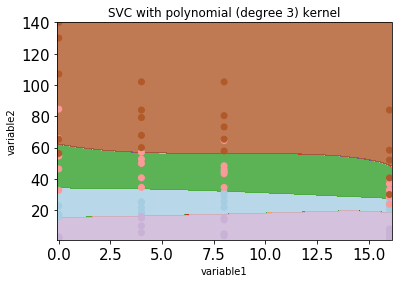

'    \n    # save all meshes\n    meshname = \'multiclassmesh\' + format(i) + \'.csv\'\n    with open(meshname, "wb") as output:\n        writer = csv.writer(output)\n        writer.writerows(list(reversed(Z)))\n'

In [29]:
# Run classifiers
# create an instance of SVM and fit data

###################################################################################################
h = .1 # step size in the mesh
###################################################################################################

C = 10  # SVM regularization parameter
svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=500, C=C).fit(X, y)
poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']

for i, clf in enumerate((svc, lin_svc, rbf_svc, poly_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    print(i)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired, alpha=0.8)
    
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
    plt.xlabel('variable1')
    plt.ylabel('variable2')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    #plt.xticks(())
    #plt.yticks(())
    plt.title(titles[i])
    print(format(clf) + ' score = ' + format(clf.score(X,y)))
    plt.show()
    i += 1 #move this to after saving block if saving meshes
'''    
    # save all meshes
    meshname = 'multiclassmesh' + format(i) + '.csv'
    with open(meshname, "wb") as output:
        writer = csv.writer(output)
        writer.writerows(list(reversed(Z)))
'''

C:\Users\a6q\AppData\Local\Continuum\Anaconda3\envs\py2\lib\site-packages\ipykernel_launcher.py:22: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Decision Tree (depth=4)score = 0.8875
KNN (k=7)score = 0.85
Kernel SVMscore = 0.9625
Soft Votingscore = 0.825


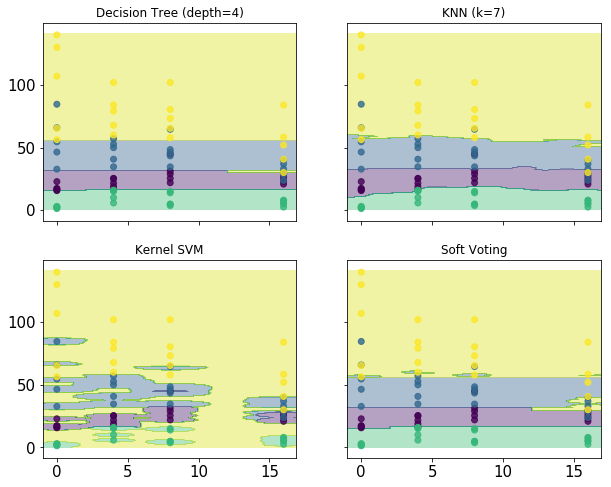

In [28]:
 #Try voting classifier
    
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Training classifiers
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=7)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2),
                                    ('svc', clf3)],
                        voting='soft', weights=[2, 1, 2])

clf1.fit(X, y)
clf2.fit(X, y)
clf3.fit(X, y)
eclf.fit(X, y)

# Plotting decision regions
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Decision Tree (depth=4)', 'KNN (k=7)',
                         'Kernel SVM', 'Soft Voting']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)
    print(format(tt) + ' score = ' + format(clf.score(X,y)))
plt.show()


In [ ]:
# NEURAL NET REGRESSOR USING SKLEARN

'''
from sknn.mlp import Regressor, Layer
from sklearn.grid_search import GridSearchCV #auto network parameter optimization
from scipy import stats
from sklearn.grid_search import RandomizedSearchCV
from sklearn.cross_validation import train_test_split
import pickle #for saving trained networks


#design network
NNstarttime = timer() #start timer
nn = Regressor(layers=[
        Layer('Sigmoid', units=4), #hidden layers
        Layer('Sigmoid', units=3),
        Layer('Linear')], #output layer
    learning_rate=0.02,
    n_iter=100)

samplestart = 0 #set start index for samples
sampleend = 100 #set end index for samples
    

#create single columns for each input/output:
rescol = np.array([]); timecol = np.array([]); presscol = np.array([])

for i in range(0,len(ROIres),2):
    rescol = np.append(rescol, ROIres[i][samplestart:sampleend]) #response
#and times and pressures
    timecol = np.append(timecol, ROIt[0][samplestart:sampleend]) #time
    presscol = np.append(presscol, ROIpress[0][samplestart:sampleend]) #pressure
    
#single pressure column with all saturation (setpoint) pressure values
setpresscol = np.ones(len(rescol))
for i in range(len(abspress)):
    setpresscol[i*(sampleend-samplestart):i+2*i*(sampleend-samplestart)] = abspress[i]

#################
#insert data to be used as columns for input matrix 
inputlist =(
    rescol,
    timecol)
#insert data to be used as columns for target matrix
targetlist = (
    presscol)
  #  presscol)
##################

#see if input/target lists are multi-dimensional and convert to matrices

if len(np.shape(inputlist)) > 1:
    inputmatrix = np.array(zip(*inputlist)) #create input matrix
else:
    inputmatrix = inputlist.reshape(len(inputlist),1)
    
if len(np.shape(targetlist)) > 1:
    targetmatrix = np.array(zip(*targetlist)) #create target matrix
else:
    targetmatrix = targetlist.reshape(len(targetlist),1)

#split into random train and test sets
inp_train, inp_test, tar_train, tar_test = train_test_split(
    inputmatrix, targetmatrix, train_size=0.5, random_state = 0)

##################
nn.fit(inp_train, tar_train) #train network
prediction = nn.predict(inp_test) #make predictions
##################

# print(nn.get_parameters()) #summarize network parameters
NNendtime = timer()  #end training timer
NNtime = (NNendtime - NNstarttime) / 60 #total training time in minutes
print('NN training time (min):' + format(NNtime))
print('testing MSE (%): ' + format(MSE(tar_test,prediction)))

# print(nn.get_parameters()) #summarize network parameters

#input and target indexes to plot:
inpindex = 0 ; tarindex = 1

#see if input and target matrices are multi-dimensional
# to prevent plotting of an invalid matrix index
if len(np.shape(inputlist)) == 1: inpindex = 0
if len(np.shape(targetlist)) == 1: tarindex = 0

xvar = zip(*inp_test)[inpindex] #data to plot as "x" variable
yvar = zip(*tar_test)[tarindex] #data to plot as "y" variable
predictvar = zip(*prediction)[tarindex] #data to plot as predictions


plt.scatter(xvar, yvar, c='b', label='data') #test data
plt.scatter(xvar, predictvar, c='g', label='predictions') # predictions
plt.scatter(xvar, abs(np.subtract(yvar, predictvar)), c='r', label='errors') #errors
plt.legend(loc='lower right')
plt.xlabel('Input')
plt.ylabel('Target - actual and predicted')
plt.title('NN predictions and errors')
plt.show()

'''

#######################################################################
# SAVE NN RESULTS TO CSV FILE
'''
NNfile = "NNresults.csv"
saveNNdata = []; NNheaders = []; savetar = []

#see if input/target lists are multi-dimensional and reshape if necessary
#save test inputs:
if len(np.shape(inputlist)) > 1:
    for i in range(len(inputlist)):
        saveNNdata.append(zip(*inp_test)[i])
        NNheaders.append('test_input' + str(i+1))
else:
    saveNNdata.append(np.reshape(inp_test,len(inp_test)))
    NNheaders.append('test_input')
    
#save test targets and predictions:
if len(np.shape(targetlist)) > 1:
    for i in range(len(targetlist)):
        saveNNdata.append(zip(*tar_test)[i]) 
        NNheaders.append('test_target' + str(i+1))
        saveNNdata.append(zip(*prediction)[i])
        NNheaders.append('prediction' + str(i+1))
else:
    saveNNdata.append(np.reshape(tar_test,len(tar_test)))
    NNheaders.append('test_target')
    saveNNdata.append(np.reshape(prediction, len(tar_test)))
    NNheaders.append('prediction')
                        

    

saveNNdata = zip(*saveNNdata)
#open CSV file
with open(NNfile, "w") as output:
    writer = csv.writer(output, lineterminator='\n')
    writer.writerow(NNheaders) #write headers
    for row in saveNNdata:
        writer.writerow(row)
'''


#grid search optimizes network among the choices you give it:
'''
gs = GridSearchCV(nn, param_grid={
    'learning_rate': [0.05, 0.01, 0.005, 0.001],
    'hidden0__units': [4,8,12]
    'hidden0__type': ['Rectifier', 'Sigmoid', 'Tanh']})
gs.fit(X,y)
'''
# or among random parameters:
'''
gs = RandomizedSearchCV(nn, param_distributions={
    'learning_rate': stats.uniform[0.001, 0.1],
    'hidden0__units': stats.radint[3,15],
    'hidden0__type': ['Rectifier', 'Sigmoid', 'Tanh']})
gs.fit(X,y)
'''

#to save trained network:
#pickle.dump(nn, open('nn.pk1', 'wb'))

#to load trained network:
# nn = pickel.load(open('nn.pk1', 'rb'))



#######################################################################


In [103]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
